In [ ]:
 pip install tf_keras

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Layer,Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization
from tensorflow.keras.activations import linear, relu, sigmoid
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import save_model
from tensorflow import keras
from tensorflow.keras import layers,models,Model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import random
from os import listdir
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras.utils as image
from sklearn.preprocessing import LabelEncoder

2024-05-12 12:43:39.447010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 12:43:39.447134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 12:43:39.597106: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES'
category = os.listdir(path)


data = {"imgpath": [] , "labels": [] }
for cat in category:
    folder = os.path.join(path, cat)
    img_list = os.listdir(folder)
    for img in img_list:
        imgpath = os.path.join(folder, img)
        data['imgpath'].append(imgpath)
        data['labels'].append(cat)
df = pd.DataFrame(data)

In [ ]:
df['labels_clean'] = df['labels'].str.extract(r'\d+\. ([^\d\-]+)')

In [ ]:
encoder = LabelEncoder()
df['encoded_labels'] = encoder.fit_transform(df['labels_clean'])
df['labels_clean'] = df['labels_clean'].str.strip()
print(df.shape)
df.head()

(27153, 4)


,imgpath,labels,labels_clean,encoded_labels
0,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3
1,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3
2,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3
3,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3
4,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema,3


In [ ]:
overrepresented_samples = df[df['labels_clean'] == 'Melanocytic Nevi (NV)']
random_list = np.random.choice(overrepresented_samples['imgpath'].tolist(), size=2000, replace=False)

undersampled_overrepresented_samples = overrepresented_samples[overrepresented_samples['imgpath'].isin(random_list)]
undersampled_overrepresented_samples = undersampled_overrepresented_samples.reset_index(drop=True)

In [ ]:
overrepresented_class = 'Melanocytic Nevi (NV)'
a = df[~(df['labels_clean'] == overrepresented_class)]
a = pd.concat([a, undersampled_overrepresented_samples])
df = a.copy()
df = df.reset_index(drop=True)

In [ ]:
train_df, test_val_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=0)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, shuffle=True, random_state=0)

print(f'train: {len(train_df) / df.shape[0] *100}% | Data(test|val): {len(test_val_df) / df.shape[0] *100}% | test: {len(test_df) / df.shape[0] *100}% | val: {len(val_df) / df.shape[0] *100}% ')

train: 79.998111693339% | Data(test|val): 20.001888306661% | test: 9.998583770004249% | val: 10.003304536656753% 


In [ ]:
train_df = train_df.reset_index(drop=True)
valid_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
def resize(img):
    size = 240
    img = tf.image.resize(img, [size,size])
    img /= 255.
    return img
def my_one_hot(feature, label):
    one_hot = tf.one_hot(label, 10)
    return feature, one_hot
def load_and_preprocess_image(path,label):
    image = tf.io.read_file(path)
    # Decode the image
    if tf.strings.regex_full_match(path, r".*\.png$"):
        image = tf.image.decode_png(image, channels=3)
    else:
        image = tf.image.decode_jpeg(image, channels=3)

    image = resize(image)
    return image, label

In [ ]:
# Training dataset
train_paths = train_df['imgpath'].values
train_labels = train_df['encoded_labels'].values
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(my_one_hot)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_paths = val_df['imgpath'].values
val_labels = val_df['encoded_labels'].values
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(my_one_hot)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Testing dataset
test_paths = test_df['imgpath'].values
test_labels = test_df['encoded_labels'].values
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(my_one_hot)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#plot
train_paths = train_df['imgpath'].values
train_labels = train_df['encoded_labels'].values
x = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
x = x.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

images = []
labels = []
for img, label in x.take(4):
    images.append(img)
    labels.append(label.numpy())

#for i in range(4):
#    plt.subplot(2,2,i+1)
#    plt.imshow(images[i])
#    plt.title(labels[i])
#plt.tight_layout()

In [ ]:
import tensorflow_hub as hub

In [ ]:
eff_v2_xl = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet21k-ft1k-b1-feature-vector/1"

In [ ]:
feature_extractor_layer = hub.KerasLayer(eff_v2_xl,
                                              trainable=False,
                                              name='feature_extraction_layer',
                                              input_shape=(240,240,3))

Attaching model 'google/efficientnet-v2/tensorflow2/imagenet21k-ft1k-b1-feature-vector/1' to your Kaggle notebook...


In [ ]:
#pretrained_model = tf.keras.applications.EfficientNetB5(
#    input_shape=(224, 224, 3),
#    include_top=False, # we don`t need a pre-trained top layer (output layer)
#    weights='imagenet',
#    pooling='max',
    #include_preprocessing=True
#)

In [ ]:
"""
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

for i, layer in enumerate(pretrained_model.layers[-3:]):
    pretrained_model.layers[i].trainable = True
        """

'\nfor i, layer in enumerate(pretrained_model.layers):\n    pretrained_model.layers[i].trainable = False\n    \nfor i, layer in enumerate(pretrained_model.layers[-3:]):\n    pretrained_model.layers[i].trainable = True\n        '

In [ ]:
class Savemodel(Callback):
    def __init__(self, filepath, monitor='val_accuracy', verbose=1, save_best_only=True):
        super(Savemodel, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_val_acc = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best_val_acc:
            if self.verbose > 0:
                print(f"\nValidation accuracy improved from {self.best_val_acc:.5f} to {current_val_acc:.5f}. Saving model.")
            self.best_val_acc = current_val_acc
            save_model(self.model, self.filepath, overwrite=True)
        else:
            if self.verbose > 0:
                print(f"\nValidation accuracy did not improve from {self.best_val_acc:.5f}.")

callbacks  = [Savemodel(filepath='best_model.h5')]

In [ ]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom(0.15),
  layers.experimental.preprocessing.RandomContrast(0.15),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
], name='AugmentationLayer')



inputs = layers.Input(shape = (240,240,3), name='inputLayer')
x = augment(inputs)
pretrain_out = feature_extractor_layer(x, training = False)

x = layers.Dense(16)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)

x = layers.Dense(10)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)

# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 240, 240, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 240, 240, 3)       0         
 ial)                                                            
                                                                 
 feature_extraction_layer (  (None, 1280)              6931124   
 KerasLayer)                                                     
                                                                 
 dense (Dense)               (None, 16)                20496     
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 batch_normalization (Batch  (None, 16)                64    

In [ ]:
for layer in model.layers[:-4]:
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_dataset,
                   validation_data=val_dataset,
                   epochs=20,
                   callbacks=[callbacks])

Epoch 1/20


I0000 00:00:1715517942.913382     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


530/530 [==============================] - ETA: 0s - loss: 1.2542 - accuracy: 0.5934
Validation accuracy improved from -inf to 0.70316. Saving model.


/tmp/ipykernel_34/1405520165.py:16: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, self.filepath, overwrite=True)


530/530 [==============================] - 277s 287ms/step - loss: 1.2542 - accuracy: 0.5934 - val_loss: 0.8951 - val_accuracy: 0.7032
Epoch 2/20
530/530 [==============================] - ETA: 0s - loss: 0.8855 - accuracy: 0.7119
Validation accuracy improved from 0.70316 to 0.72723. Saving model.
530/530 [==============================] - 179s 271ms/step - loss: 0.8855 - accuracy: 0.7119 - val_loss: 0.8456 - val_accuracy: 0.7272
Epoch 3/20
530/530 [==============================] - ETA: 0s - loss: 0.7382 - accuracy: 0.7650
Validation accuracy improved from 0.72723 to 0.77631. Saving model.
530/530 [==============================] - 178s 270ms/step - loss: 0.7382 - accuracy: 0.7650 - val_loss: 0.6872 - val_accuracy: 0.7763
Epoch 4/20
530/530 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.8011
Validation accuracy improved from 0.77631 to 0.77867. Saving model.
530/530 [==============================] - 178s 270ms/step - loss: 0.6168 - accuracy: 0.8011 - val_loss

In [ ]:
model.evaluate(test_dataset)

67/67 [==============================] - 9s 134ms/step - loss: 0.6725 - accuracy: 0.8196


[0.6724696755409241, 0.8196411728858948]

In [ ]:
my_reloaded_model = tf.keras.models.load_model(
       ('/kaggle/working/best_model.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

Attaching model 'google/efficientnet-v2/tensorflow2/imagenet21k-ft1k-b1-feature-vector/1' to your Kaggle notebook...


In [ ]:
my_reloaded_model.evaluate(test_dataset)

67/67 [==============================] - 6s 70ms/step - loss: 0.6676 - accuracy: 0.8281


[0.6675883531570435, 0.8281397819519043]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

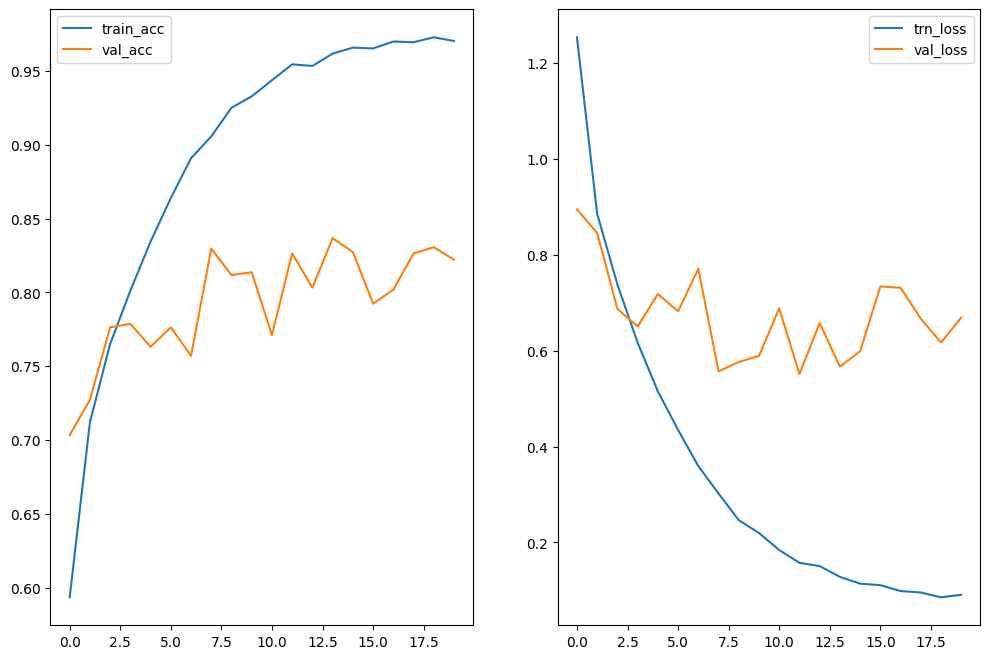

In [ ]:
import seaborn as sns
def plot(history):
    trn_loss = history.history['loss']
    val_loss = history.history['val_loss']

    trn_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epoch = range(len(history.history['loss']))

    f, ax = plt.subplots(1,2,figsize=(12,8))
    #train
    sns.lineplot(x=epoch, y=trn_acc, label='train_acc', ax=ax[0])
    sns.lineplot(x=epoch, y=val_acc, label='val_acc', ax=ax[0])

    #validation
    sns.lineplot(x=epoch, y=trn_loss, label='trn_loss', ax=ax[1])
    sns.lineplot(x=epoch, y=val_loss, label='val_loss', ax=ax[1])


    plt.show()
plot(history)

In [ ]:
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mapping

{'Atopic Dermatitis': 0,
 'Basal Cell Carcinoma (BCC)': 1,
 'Benign Keratosis': 2,
 'Eczema': 3,
 'Melanocytic Nevi (NV)': 4,
 'Melanoma': 5,
 'Psoriasis pictures Lichen Planus and related diseases': 6,
 'Seborrheic Keratoses and other Benign Tumors': 7,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 8,
 'Warts Molluscum and other Viral Infections': 9}

In [ ]:
def load_pred(imgpath, imgsize=240):
    img = tf.io.read_file(imgpath)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (imgsize,imgsize))
    img = img/255.
    return img

def preds(model, test_df=test_df, label_mapping=label_mapping):
    random_img = test_df['imgpath'].sample(10)
    for i in range(10):
        img = load_pred(random_img.iloc[i])
        pred = model.predict(tf.expand_dims(img, axis=0))
        pred_class_encoded = np.argmax(pred)
        pred_labels = [label for label, value in label_mapping.items() if pred_class_encoded == value]  # Use pred instead of preds

        actual_index = random_img.index[i]
        actual_label_encoded = test_df['encoded_labels'].iloc[actual_index]
        actual_label = test_df['labels_clean'].iloc[actual_index]

        print("Predicted label for image", i+1, ":", pred_labels)

        if pred_class_encoded != actual_label_encoded:
            print(f"Predicted wrong! | Actual label is {actual_label}")

In [ ]:
preds(my_reloaded_model)

1/1 [==============================] - 0s 28ms/step
Predicted label for image 1 : ['Tinea Ringworm Candidiasis and other Fungal Infections']
1/1 [==============================] - 0s 30ms/step
Predicted label for image 2 : ['Psoriasis pictures Lichen Planus and related diseases']
Predicted wrong! | Actual label is Eczema
1/1 [==============================] - 0s 31ms/step
Predicted label for image 3 : ['Benign Keratosis']
Predicted wrong! | Actual label is Melanocytic Nevi (NV)
1/1 [==============================] - 0s 30ms/step
Predicted label for image 4 : ['Melanocytic Nevi (NV)']
1/1 [==============================] - 0s 27ms/step
Predicted label for image 5 : ['Tinea Ringworm Candidiasis and other Fungal Infections']
Predicted wrong! | Actual label is Psoriasis pictures Lichen Planus and related diseases
1/1 [==============================] - 0s 28ms/step
Predicted label for image 6 : ['Psoriasis pictures Lichen Planus and related diseases']
1/1 [==============================] - 

1/1 [==============================] - 0s 27ms/step
predicted as: Melanoma


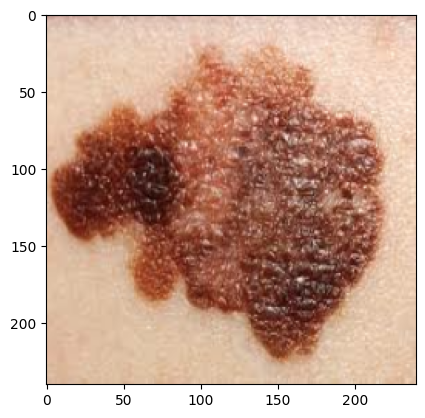

In [ ]:
img_new = '/kaggle/input/melanoma/melanoma.jpeg'
img_new = load_pred(img_new)
img_new_pred = my_reloaded_model.predict(tf.expand_dims(img_new, axis=0))
img_new_pred = np.argmax(img_new_pred)
for label, value in label_mapping.items():
    if img_new_pred == value:
        print(f'predicted as: {label}')

plt.imshow(img_new)